# 1. Import

This is a complete guide of using language model to perform spam detection.

The objective is straightforward: Given a labeled data, where one column is text message, and another column is the label: spam or  not spam, build a model to detect non spam message.

In [213]:
import string
import nltk
import itertools
import scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.utils.fixes import signature

from sklearn.pipeline import Pipeline

from yellowbrick.classifier import ROCAUC

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

%matplotlib inline

# 2. Define useful function

In [2]:
def train_t_s(vector, labels):
    Xtrain, Xtest, ytrain, ytest = train_test_split(vector, labels.astype(int), test_size=0.2, random_state=42)
    print(Xtrain.shape, ytrain.shape, Xtest.shape)
    return( Xtrain, Xtest, ytrain, ytest )

def vector(vectorizer, df_col):
    vector = vectorizer.fit_transform(df_col)
    print(vector.shape)
    feature_names = vectorizer.get_feature_names()
    return(vector, feature_names)
    

In [248]:
# function to train classifier
def train_classifier(clf, X_train, y_train):    
    return(clf.fit(X_train, y_train))

# function to predict features 
def predict_labels(clf, features):
    return(clf.predict(features))

# function nlp Learn the vocabulary dictionary and return term-document matrix.
def fit_transf(vectorizer,df_lemma):
    return(vectorizer.fit_transform(df_lemma) )
    
# reduce number of features  
def chi2_kbest(Xtrain, ytrain, Xtest, feature_names, k_n):
    '''
    k_n = num of features
    '''
    ch2 = SelectKBest(chi2, k=k_n)
    Xtrain_red = ch2.fit_transform(Xtrain, ytrain)
    Xtest_red  = ch2.transform(Xtest)
    for i in ch2.get_support().nonzero():
        feature_names_best = np.array(feature_names)[i.astype(int)]
    return(Xtrain_red, Xtest_red, feature_names_best)


# plot results of chi2 best
def chi2_kbest_plot(Xtrain, ytrain, Xtest, feature_names):

    chi2score = chi2(Xtrain, ytrain)[0]
    plt.figure(figsize=(15,10))
    
    wscores = zip(feature_names, chi2score)
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-40:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.xlabel('$\chi^2$')

In [144]:
# Compute Sparsicity = Percentage of Non-Zero cells
def sparc(vector):
    data_dense = vector.todense()
    print("Sparsicity:", ((data_dense > 0).sum()/data_dense.size)*100, "%")
    
def metric(clf, Xtest, ytest):
    pred = predict_labels(clf, Xtest)
    pre  = precision_score(ytest, pred)
    acc  = accuracy_score(ytest, pred )
    rec  = recall_score(ytest, pred)
    f1   = f1_score(ytest, pred)
    cm   = confusion_matrix(ytest, pred)
    print('Accuracy = ', acc*100,'%, Recall = ', rec*100,'%, Precision = ', pre*100,'%, f1 =', f1*100 )
    return(pre, acc, rec, cm, f1)

In [5]:
#function to plot count
def plot_count(label,df):
    sns.set(style='darkgrid')
    sns.countplot(x = str(label),data = df,
              order = df[label].value_counts().index,palette="rocket")
    plt.title('Distribution of Classes')
    plt.show()

In [6]:
# Validation curve
def val_curve(par_range, param_name, estimator, cv, scoring, Xtrain, ytrain, name):
    '''
    par_range = np.linspace(0.01,1,num=20)
    param_name = str(name)
    scoring = str() ex "recall"
    name = na,e of the estimator for plot
    '''

    train_scores, test_scores = validation_curve(estimator, Xtrain, ytrain, param_name=param_name, param_range=par_range,
                                             cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve"+str(name))
    plt.xlabel( str(param_name) )
    plt.ylabel(str(scoring)+" Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    test_error =[]
    train_error = []
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='recall')
    train_error.append(np.std(train_scores, axis=1))
    test_error.append(np.std(test_scores, axis=1))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print('Train score mean ',train_scores_mean,' +- ',train_scores_std)
    print('Test score mean  ',test_scores_mean,' +- ',test_scores_std)
    print('cv: ',cv)
    print('train size:',train_sizes)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return (plt,train_error,test_error)

In [9]:
def ROC_AUC(estimator, Xtrain, ytrain, Xtest, ytest):
    '''
    estimator = ComplementNB(alpha=alpha_best)
    '''
    classes = ["Not Flagged", "Flagged"]
    roc_model = ROCAUC(estimator, classes=classes)
    roc_model.fit(Xtrain, ytrain)
    roc_model.score(Xtest, ytest)  # Evaluate the model on the test data
    return( roc_model.poof() )

In [10]:
def prec_recall(clf, Xtest, ytest):
    '''
    plot precision recall curve
    clf = estimator ex. MNB = ComplementNB()
    '''
    y_score = clf.predict_proba(Xtest)
    precision, recall, thr = precision_recall_curve(ytest, y_score[:,1])

    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

In [176]:
def plot_res(objects, pred_val, name):
    '''plot results of different models
    objects = ex. objects = ('Comp-NB', 'DT', 'AdaBoost', 'RF','LR','SVC')
    pred_val = score you want to plot
    name = ex 'Accuracy Score'
    '''
    y_pos = np.arange(len(objects))
    y_val = [ x for x in pred_val]
    plt.bar(y_pos,y_val, align='center', alpha=0.7)
    plt.xticks(y_pos, objects)
    plt.ylabel(str(name))
    plt.title(str(name)+' of Models')
    return(plt.show() )

In [11]:
def k_fold(n, estimator, Xtrain, ytrain, scoring):
    '''
    n = number of split
    estimator = ComplementNB(alpha=alpha_best)
    scoring = scoring ex. "recall"
    '''
    k_fold = KFold(n_splits=n, random_state=42)
    scores = cross_val_score(estimator, Xtrain, ytrain, cv=k_fold, scoring=scoring)
    print('Average scoring = ',np.mean(scores),' +/- ',np.std(scores))

In [46]:
def top_feat(vectorizer,feature_name, top):
    ''' 
    top = top feature wanted 
    '''
    indices = np.argsort(vectorizer.idf_)[::-1]
    top_n = int(top)
    top_features = [feature_name[i] for i in indices[:top_n]]
    print (top_features)

In [12]:
def show_most_informative_features(feature_names, clf, n):
    '''
    feature_names = vectorizer.get_feature_names()
    clf = estimator ex. MNB = ComplementNB()
    n = number of most important feature
    '''
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2) )

In [103]:
def feat_clust_pca(vector,df_lab):
    '''
    df_lab = labels in the df ex. Total_df['Label']
    '''

    pca = PCA(n_components=2).fit(vector.todense())
    data2D = pca.transform(vector.todense())
    plt.scatter(data2D[:,0], data2D[:,1], c = df_lab, cmap='spring')
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()

In [104]:
def feat_clust_tsne(vector,df_lab):
    '''
    df_lab = labels in the df ex. Total_df['Label']
    '''
    X_embedded = TSNE(n_components=2).fit_transform(vector.todense())
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c = df_lab, cmap='summer')
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()

# 3. Prepare the data


In [79]:
# import the data for spam and non
ads_nice = pd.read_pickle('Total_labelPositive_adsTEXT_+_counts_CLEAN_withcommom_feb8.pkl')
spam_ads2 =pd.read_pickle('Total_labelSPAM_adsTEXT_+_counts_CLEAN_withcommom_feb8.pkl')

In [80]:
# add a label
ads_nice['Label'] = '1'
spam_ads2['Label'] = '0'

In [81]:
# select only column you are interested in
ads_nice = ads_nice[['ads_clean_freq','Label']]
spam_ads2= spam_ads2[['ads_clean_freq','Label']]

In [82]:
# check the shape
print(ads_nice.shape, spam_ads2.shape)

(1177, 2) (676, 2)


In [83]:
# Add the two datasets
Total_df = spam_ads2.append(ads_nice)

In [84]:
# check the shape
print(Total_df.shape)

(1853, 2)


In [85]:
# Drop duplicate and NAN values
Total_df = Total_df.drop_duplicates(subset = ['ads_clean_freq'])
Total_df.dropna(inplace=True)

In [86]:
# check the shape after dropping duplicate
print(Total_df.shape)

(1553, 2)


In [87]:
# Check the number of entries per class
Total_df['Label'].value_counts()

1    984
0    569
Name: Label, dtype: int64

In [88]:
# check the dataset (Are each entries unique?)
Total_df.describe()

,ads_clean_freq,Label
count,1553,1553
unique,1553,2
top,lily naughty girlsweet friendly outdoing defin...,1
freq,1,984


Are the class balanced?
Plot the distribution

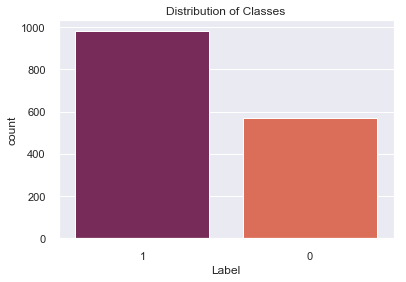

In [89]:
plot_count('Label', Total_df)

# Resample imbalance Class (Not using it)

create a new DataFrame with an up-sampled minority class. Here are the steps:

    1) separate observations from each class into different DataFrames.
    2) resample the minority class with replacement, setting the number of samples to match that of the majority class.
    3) combine the up-sampled minority class DataFrame with the original majority class DataFrame.

from sklearn.utils import resample

# 
Separate majority and minority classes
df_minority = Total_df[Total_df['Label']==0]
df_majority = Total_df[Total_df['Label']==1]

# 
Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=198,     # to match minority class
                                 random_state=123) # reproducible results
 
# 
Combine minority class with downsampled majority class
#df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
#
Display new class counts
#df_downsampled.balance.value_counts()

# Bag og Words N= 1, n=2
Still undecided if I should use lemmatizer or stemmatizer. 
I will try both

In [90]:
# create the lemmatizer
lemmatizer = WordNetLemmatizer()
#apply lemmatizer 
Total_df['lemmatize'] = Total_df['ads_clean_freq'].apply(lemmatizer.lemmatize)

In [91]:
# create the stem
stemmer = PorterStemmer()
#apply stem
Total_df['stem'] = Total_df['ads_clean_freq'].apply(stemmer.stem)

In [92]:
# Create the counter Vectorizer
count_vect_n1 = CountVectorizer(ngram_range=(1, 1), analyzer='word', stop_words = 'english')#, min_df=1)
count_vect_n2 = CountVectorizer(ngram_range=(1, 2), analyzer='word', stop_words = 'english')#, min_df=1)

# TFIDF

In [93]:
# Create the TFIDF vectorizer
vectorizer  = TfidfVectorizer(analyzer='word',stop_words = 'english')

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

# Trasform Words into Vectors

In [94]:
# BoW n=1 for lemmatize and stem 
vector_bow1_lem = fit_transf(count_vect_n1,Total_df['lemmatize'])
vector_bow1_ste = fit_transf(count_vect_n1, Total_df['stem'])
# BoW n=2 for lemmatize and stem 
vector_bow2_lem = fit_transf(count_vect_n2,Total_df['lemmatize'])
vector_bow2_ste = fit_transf(count_vect_n2, Total_df['stem'])
# TFIDF for lemmatize and stem 
vector_tfidf_lem = fit_transf(vectorizer,Total_df['lemmatize'])
vector_tfidf_ste = fit_transf(vectorizer, Total_df['stem'])

In [95]:
# get feature name
feature_names_n1    = count_vect_n1.get_feature_names()
feature_names_n2    = count_vect_n2.get_feature_names()
feature_names_tfidf = vectorizer.get_feature_names()

In [96]:
# prin top feature for tfidf
top_feat(vectorizer,    feature_names_tfidf,    10)

['ï¼ï½', 'onlyxa', 'oilxanmin', 'ofxasierra', 'ofxani', 'ofnyour', 'offnxansend', 'offncome', 'office', 'dollar']


# Visualize the features
When you use Bag of Words, each of your sentences gets represented in a high dimensional 
space of length equal to the vocabulary. 
If you want to represent this in 2D you need to reduce the dimension,
for example using PCA with two components:


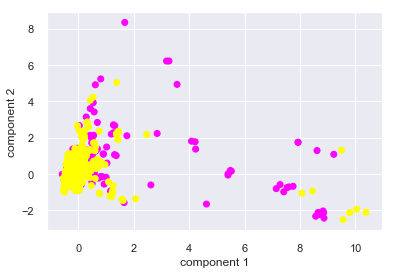

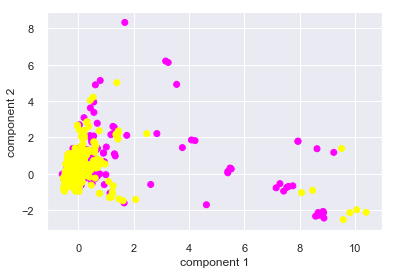

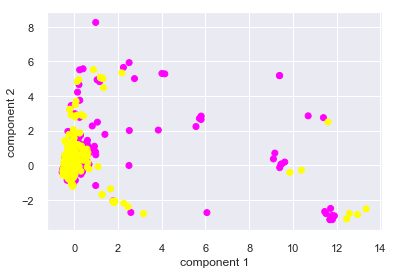

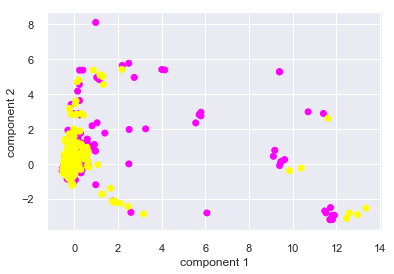

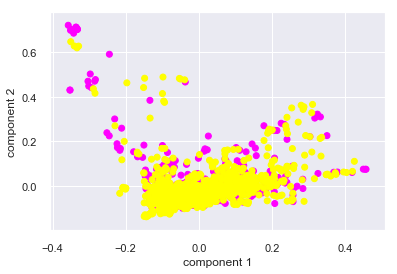

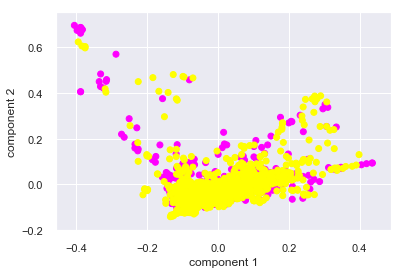

In [98]:
feat_clust_pca(vector_bow1_lem,Total_df['Label'])
feat_clust_pca(vector_bow1_ste,Total_df['Label'])

feat_clust_pca(vector_bow2_lem,Total_df['Label'])
feat_clust_pca(vector_bow2_ste,Total_df['Label'])

feat_clust_pca(vector_tfidf_lem,Total_df['Label'])
feat_clust_pca(vector_tfidf_ste,Total_df['Label'])

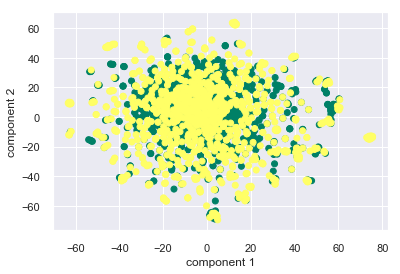

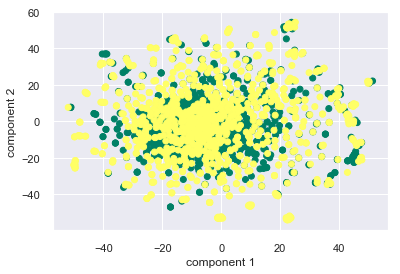

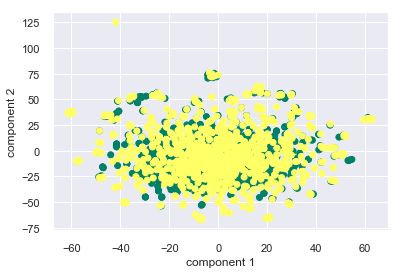

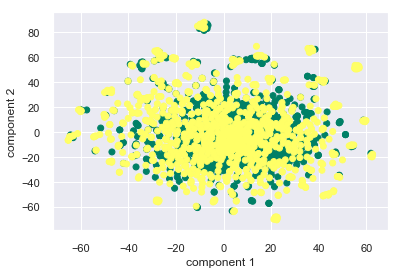

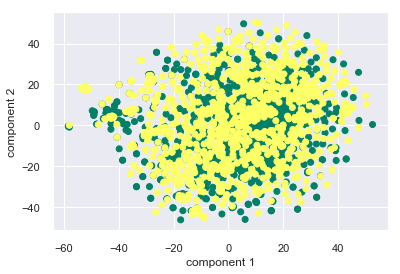

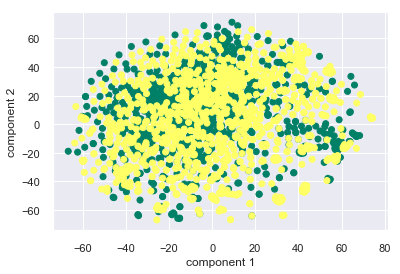

In [105]:
feat_clust_tsne(vector_bow1_lem,Total_df['Label'])
feat_clust_tsne(vector_bow1_ste,Total_df['Label'])

feat_clust_tsne(vector_bow2_lem,Total_df['Label'])
feat_clust_tsne(vector_bow2_ste,Total_df['Label'])

feat_clust_tsne(vector_tfidf_lem,Total_df['Label'])
feat_clust_tsne(vector_tfidf_ste,Total_df['Label'])

# Sparcicity for the matrix

In [109]:
sparc(vector_bow1_lem)
sparc(vector_bow1_ste)
sparc(vector_bow2_lem)
sparc(vector_bow2_ste)
sparc(vector_tfidf_lem)
sparc(vector_tfidf_ste)

Sparsicity: 0.4922694360188611 %
Sparsicity: 0.477385760085288 %
Sparsicity: 0.20413018063322785 %
Sparsicity: 0.20149022061667896 %
Sparsicity: 0.4922694360188611 %
Sparsicity: 0.477385760085288 %


# 2. Prediction
Before doing analysis, we have to decide the metric to compare between different models
We want recall to be the best, aka the number of false negative to be the lowest


In [110]:
accuracy = {}
recall    = {}
confusion_mat = {}
precision = {}
predictions = {}
# BoW 1
accuracy_bow1 = {}
recall_bow1   = {}
confusion_mat_bow1 = {}
precision_bow1 = {}
predictions_bow1 = {}
# BoW 2
accuracy_bow2 = {}
recall_bow2   = {}
confusion_mat_bow2 = {}
precision_bow2 = {}
predictions_bow2   = {}
# Tfidf
accuracy_tfidf = {}
recall_tfidf   = {}
confusion_mat_tfidf = {}
precision_tfidf = {}
predictions_tfidf   = {}

# Split the dataset

In [111]:
labels = Total_df["Label"]
labels = labels.astype(int)

## Initial text features:

In [113]:
Xtrain_bow1_lem,  Xtest_bow1_lem,  ytrain_bow1_lem,  ytest_bow1_lem  = train_t_s(vector_bow1_lem, labels)
Xtrain_bow1_ste,  Xtest_bow1_ste,  ytrain_bow1_ste,  ytest_bow1_ste  = train_t_s(vector_bow1_ste, labels)
Xtrain_bow2_lem,  Xtest_bow2_lem,  ytrain_bow2_lem,  ytest_bow2_lem  = train_t_s(vector_bow2_lem, labels)
Xtrain_bow2_ste,  Xtest_bow2_ste,  ytrain_bow2_ste,  ytest_bow2_ste  = train_t_s(vector_bow2_ste, labels)
Xtrain_tfidf_lem, Xtest_tfidf_lem, ytrain_tfidf_lem, ytest_tfidf_lem = train_t_s(vector_tfidf_lem, labels)
Xtrain_tfidf_ste, Xtest_tfidf_ste, ytrain_tfidf_ste, ytest_tfidf_ste = train_t_s(vector_tfidf_ste, labels)

(1242, 4312) (1242,) (311, 4312)
(1242, 4449) (1242,) (311, 4449)
(1242, 20959) (1242,) (311, 20959)
(1242, 21240) (1242,) (311, 21240)
(1242, 4312) (1242,) (311, 4312)
(1242, 4449) (1242,) (311, 4449)


# Initialize the different models

In [198]:
A = ComplementNB(alpha=1.0,fit_prior=True)
B = DecisionTreeClassifier(random_state=42, class_weight='balanced')
C = AdaBoostClassifier(n_estimators=100) 
D = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42,class_weight='balanced')
E = LogisticRegression(solver = 'lbfgs',penalty='l2',class_weight ='balanced')
F = SVC(kernel='linear',gamma='auto', class_weight='balanced')

# Fit, predict and get scores

In [199]:
# Creates a list containing 5 lists, each of 8 items, all set to 0
w, h = 4, 6;
Matrix = [[0 for x in range(w)] for y in range(h)] 

In [200]:
Matrix[0][:] = [Xtrain_bow1_lem,  Xtest_bow1_lem,  ytrain_bow1_lem,  ytest_bow1_lem] 
Matrix[1][:] = [Xtrain_bow1_ste,  Xtest_bow1_ste,  ytrain_bow1_ste,  ytest_bow1_ste]
Matrix[2][:] = [Xtrain_bow2_lem,  Xtest_bow2_lem,  ytrain_bow2_lem,  ytest_bow2_lem]
Matrix[3][:] = [Xtrain_bow2_ste,  Xtest_bow2_ste,  ytrain_bow2_ste,  ytest_bow2_ste]
Matrix[4][:] = [Xtrain_tfidf_lem, Xtest_tfidf_lem, ytrain_tfidf_lem, ytest_tfidf_lem]
Matrix[5][:] = [Xtrain_tfidf_ste, Xtest_tfidf_ste, ytrain_tfidf_ste, ytest_tfidf_ste ]

In [201]:
# matrix of scores filled with: 
# [train* model] [pre, acc, rec, cm, f1]
score_pre = np.zeros((6, 6) , dtype=object)
score_acc = np.zeros((6, 6) , dtype=object)
score_rec = np.zeros((6, 6) , dtype=object)
score_cm  = np.zeros((6, 6) , dtype=object)
score_f1  = np.zeros((6, 6) , dtype=object)


In [202]:
# loop to call function for each model
clf  = [A,B,C,D,E,F]
for y in range(0,h):
    for a in range(len(clf)):
        train_classifier(clf[a], Matrix[y][0], Matrix[y][2])
        y_pred = predict_labels(clf[a],Matrix[y][1])
        print('for model = '+str(a))
        score_pre[y][a], score_acc[y][a], score_rec[y][a], score_cm[y][a], score_f1[y][a] = metric(clf[a], Matrix[y][1], Matrix[y][3])
        

for model = 0
Accuracy =  73.31189710610933 %, Recall =  89.34010152284264 %, Precision =  73.94957983193278 %, f1 = 80.91954022988506
for model = 1
Accuracy =  70.7395498392283 %, Recall =  78.1725888324873 %, Precision =  76.23762376237624 %, f1 = 77.19298245614034
for model = 2
Accuracy =  71.06109324758843 %, Recall =  87.30964467005076 %, Precision =  72.57383966244726 %, f1 = 79.26267281105991
for model = 3
Accuracy =  71.70418006430869 %, Recall =  78.1725888324873 %, Precision =  77.38693467336684 %, f1 = 77.77777777777779
for model = 4
Accuracy =  74.91961414790997 %, Recall =  86.80203045685279 %, Precision =  76.68161434977578 %, f1 = 81.42857142857143
for model = 5
Accuracy =  72.9903536977492 %, Recall =  81.7258883248731 %, Precision =  77.03349282296651 %, f1 = 79.3103448275862
for model = 0
Accuracy =  73.63344051446946 %, Recall =  88.83248730964468 %, Precision =  74.46808510638297 %, f1 = 81.01851851851852
for model = 1
Accuracy =  69.45337620578779 %, Recall =  73.0

# Check different scores results

In [203]:
objects = ('Comp-NB', 'DT', 'AdaBoost', 'RF','LR','SVC')


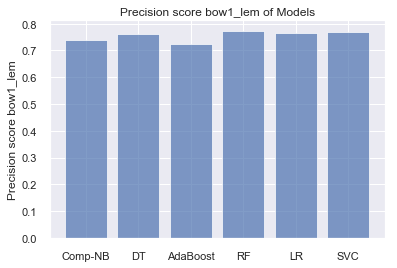

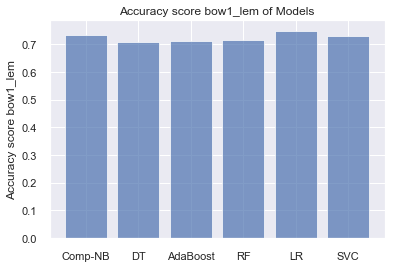

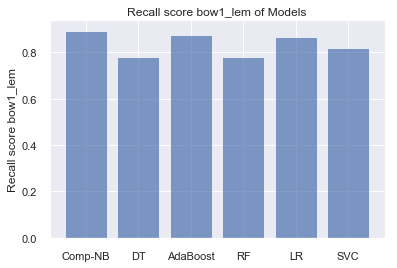

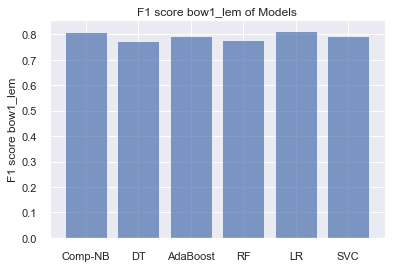

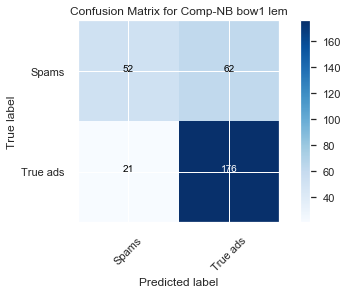

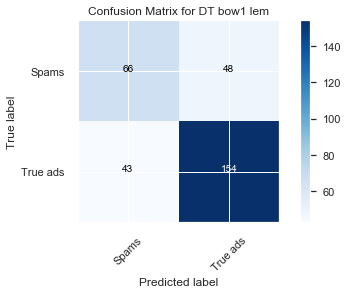

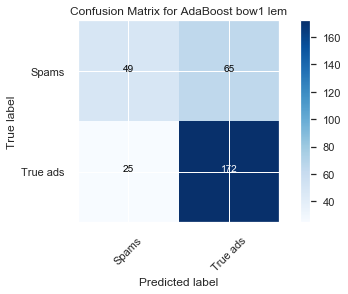

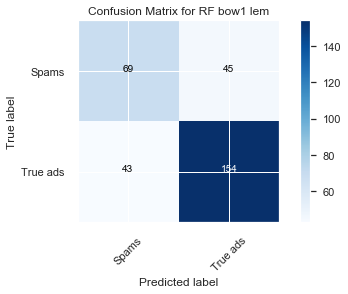

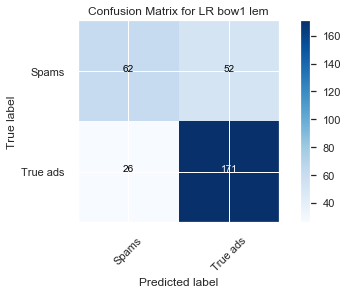

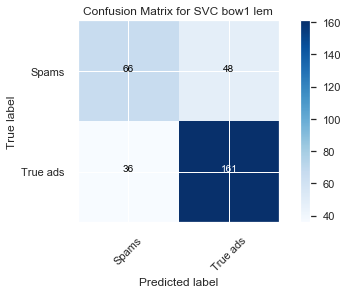

In [204]:
# ploating data for the scores/ model
# bow1_lem
plot_res(objects,score_pre[0][:] ,"Precision score bow1_lem")
plot_res(objects,score_acc[0][:] ,"Accuracy score bow1_lem")
plot_res(objects,score_rec[0][:] ,"Recall score bow1_lem")
plot_res(objects,score_f1[0][:] , "F1 score bow1_lem")
for a in range(len(clf)):
    plot_confusion_matrix(score_cm[0][a], classes=['Spams','True ads'],normalize=False, title='Confusion Matrix for '+str(objects[a])+' bow1 lem',cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()

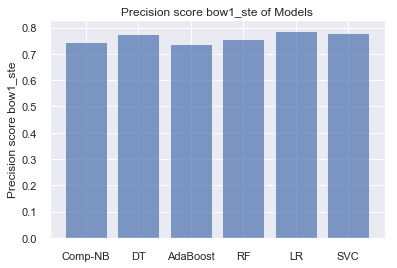

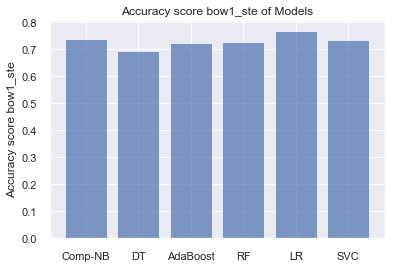

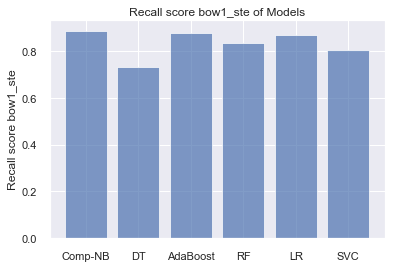

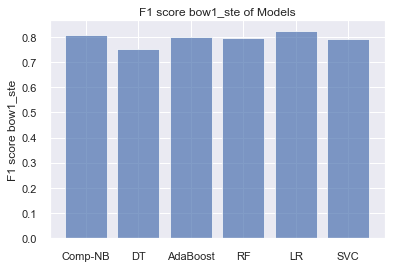

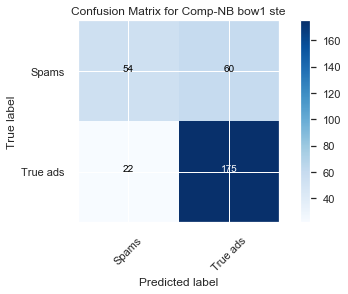

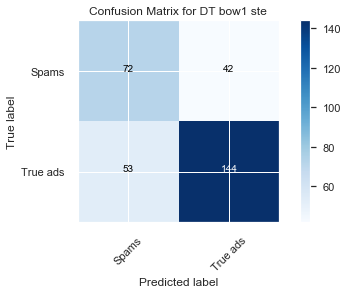

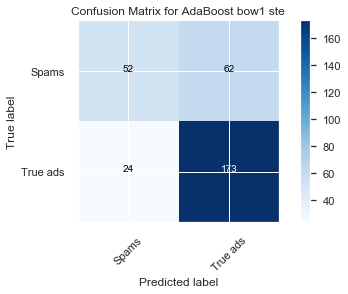

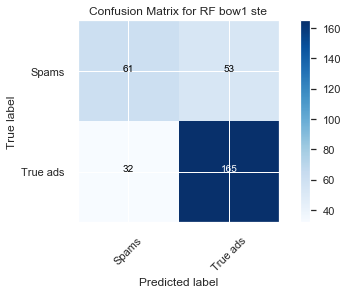

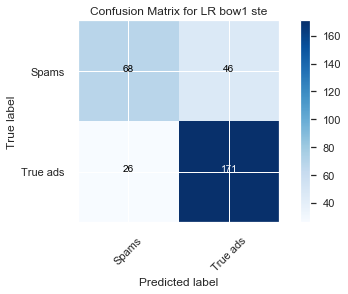

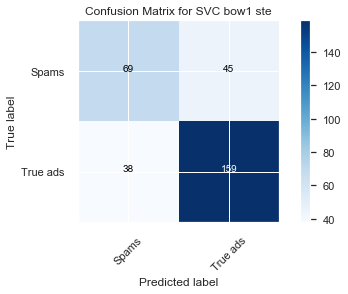

In [205]:
#bow1_ste
plot_res(objects,score_pre[1][:] ,"Precision score bow1_ste")
plot_res(objects,score_acc[1][:] ,"Accuracy score bow1_ste")
plot_res(objects,score_rec[1][:] ,"Recall score bow1_ste")
plot_res(objects,score_f1[1][:] , "F1 score bow1_ste")
for a in range(len(clf)):
    plot_confusion_matrix(score_cm[1][a], classes=['Spams','True ads'],normalize=False, title='Confusion Matrix for '+str(objects[a])+' bow1 ste',cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()

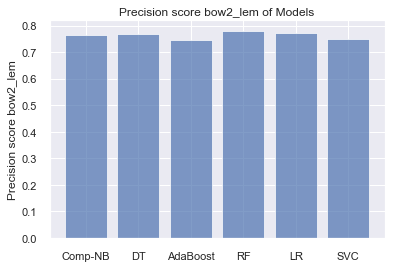

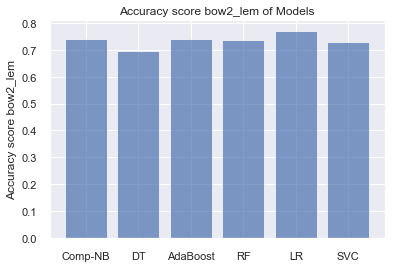

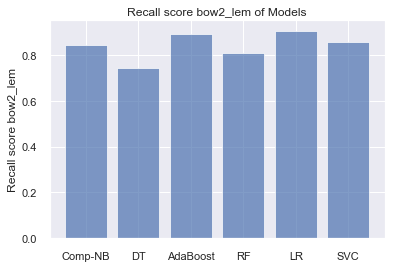

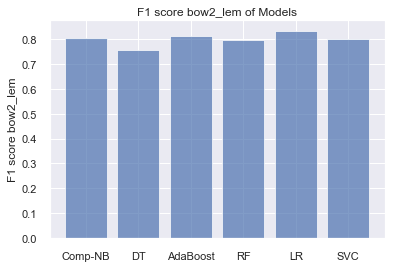

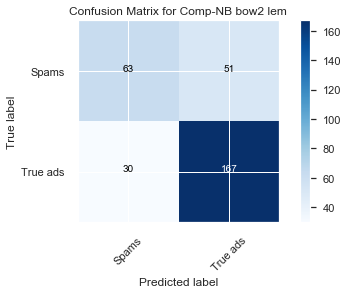

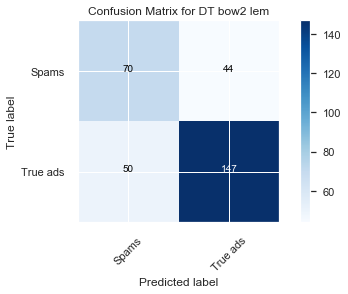

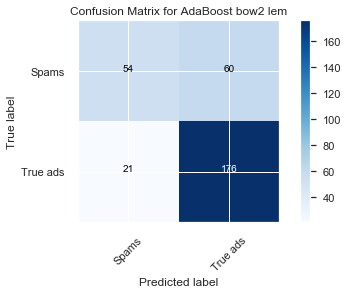

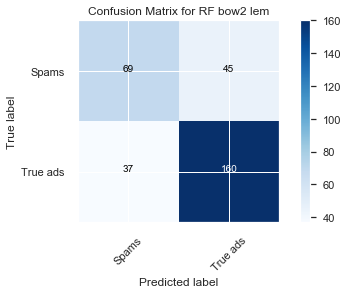

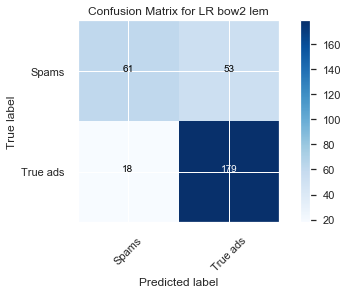

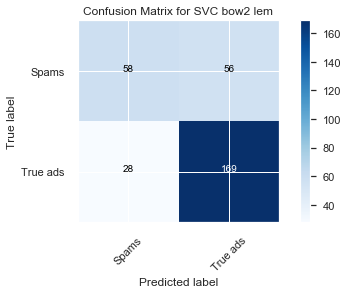

In [206]:
#bow2_ lem
plot_res(objects,score_pre[2][:] ,"Precision score bow2_lem")
plot_res(objects,score_acc[2][:] ,"Accuracy score bow2_lem")
plot_res(objects,score_rec[2][:] ,"Recall score bow2_lem")
plot_res(objects,score_f1[2][:] , "F1 score bow2_lem")
for a in range(len(clf)):
    plot_confusion_matrix(score_cm[2][a], classes=['Spams','True ads'],normalize=False, title='Confusion Matrix for '+str(objects[a])+' bow2 lem',cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()

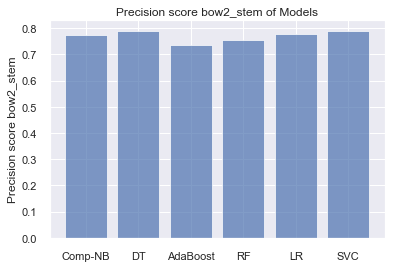

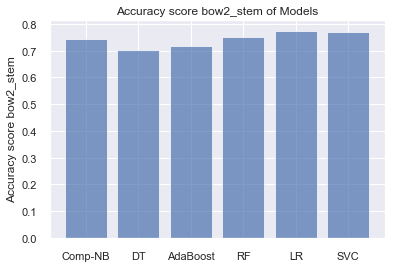

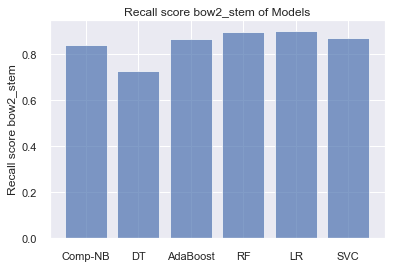

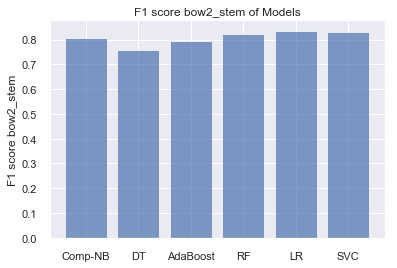

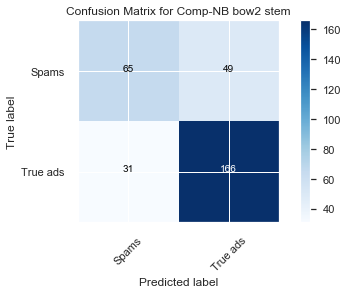

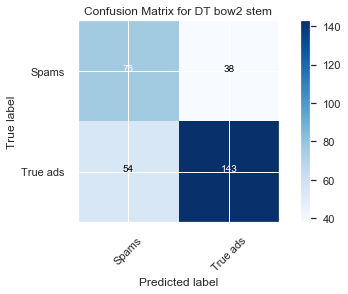

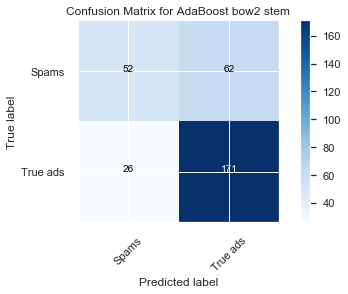

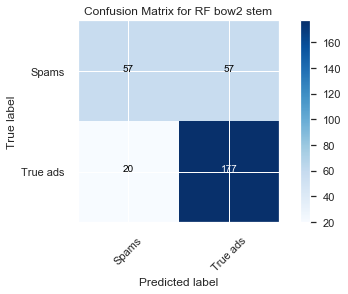

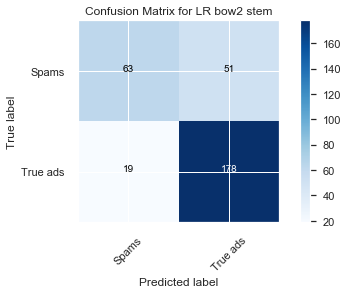

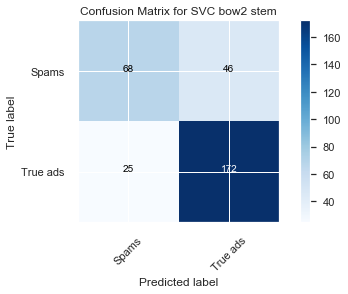

In [207]:
#bow2_ stem
plot_res(objects,score_pre[3][:] ,"Precision score bow2_stem")
plot_res(objects,score_acc[3][:] ,"Accuracy score bow2_stem")
plot_res(objects,score_rec[3][:] ,"Recall score bow2_stem")
plot_res(objects,score_f1[3][:] , "F1 score bow2_stem")
for a in range(len(clf)):
    plot_confusion_matrix(score_cm[3][a], classes=['Spams','True ads'],normalize=False, title='Confusion Matrix for '+str(objects[a])+' bow2 stem',cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()

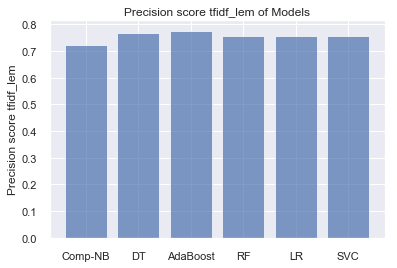

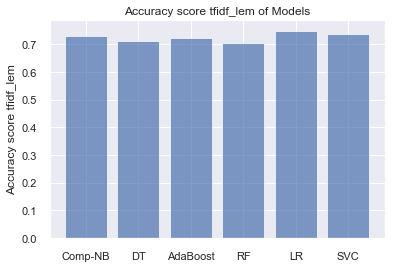

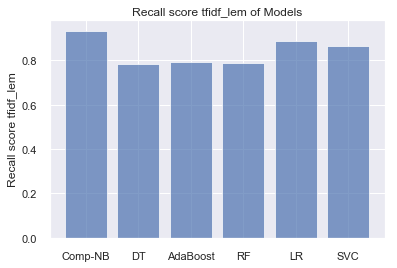

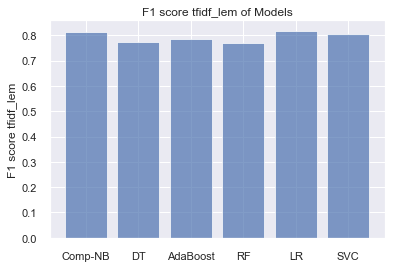

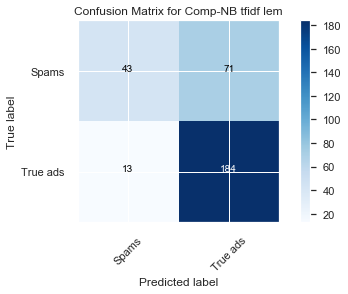

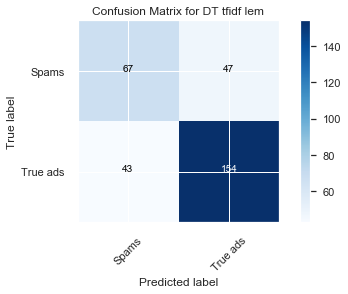

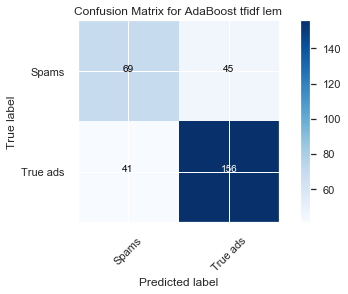

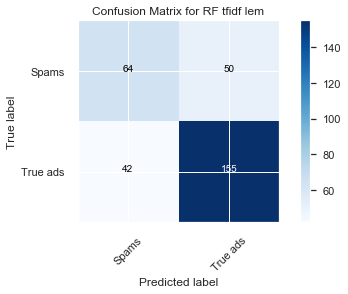

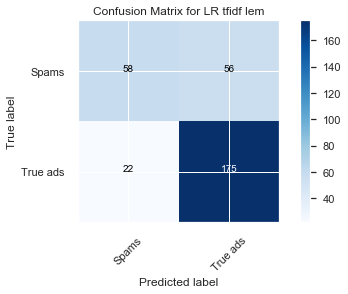

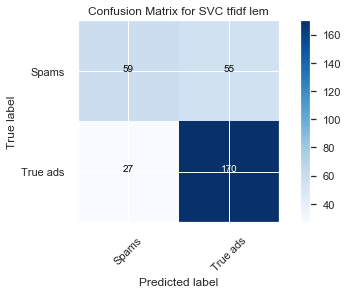

In [208]:
#tfidf lem
plot_res(objects,score_pre[4][:] ,"Precision score tfidf_lem")
plot_res(objects,score_acc[4][:] ,"Accuracy score tfidf_lem")
plot_res(objects,score_rec[4][:] ,"Recall score tfidf_lem")
plot_res(objects,score_f1[4][:] , "F1 score tfidf_lem")
for a in range(len(clf)):
    plot_confusion_matrix(score_cm[4][a], classes=['Spams','True ads'],normalize=False, title='Confusion Matrix for '+str(objects[a])+' tfidf lem',cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()

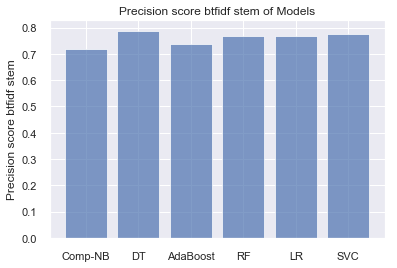

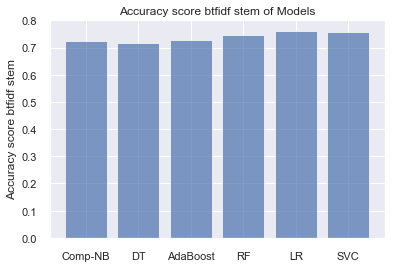

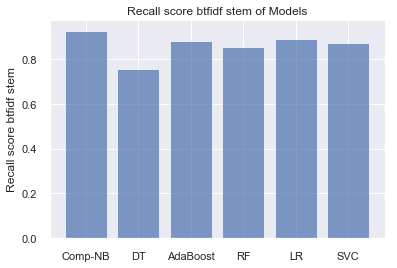

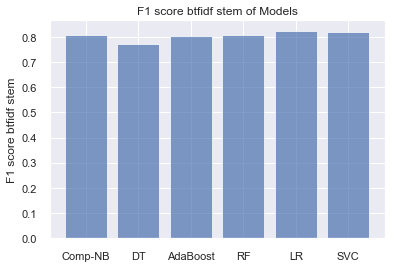

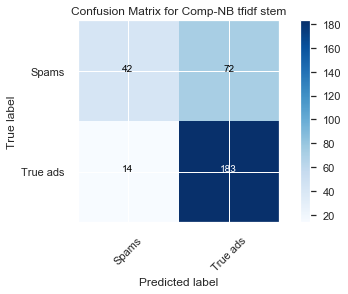

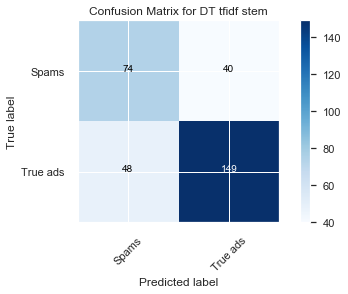

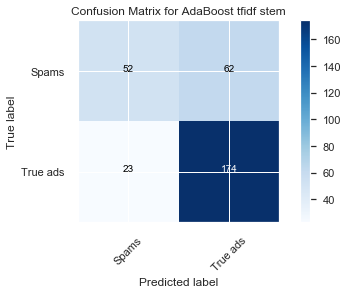

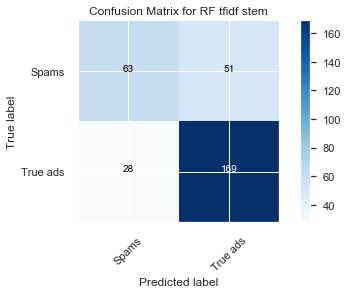

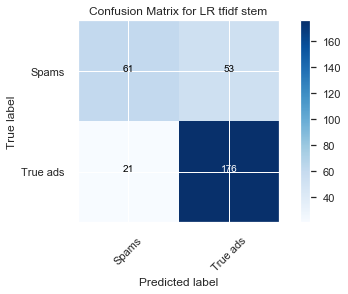

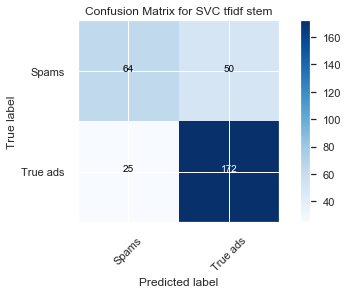

In [209]:
#tfidf stem
plot_res(objects,score_pre[5][:] ,"Precision score btfidf stem")
plot_res(objects,score_acc[5][:] ,"Accuracy score btfidf stem")
plot_res(objects,score_rec[5][:] ,"Recall score btfidf stem")
plot_res(objects,score_f1[5][:] , "F1 score btfidf stem")
for a in range(len(clf)):
    plot_confusion_matrix(score_cm[5][a], classes=['Spams','True ads'],normalize=False, title='Confusion Matrix for '+str(objects[a])+' tfidf stem',cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()

# Learning curve and errors for best ones

Train score mean  [0.99972088 0.99965826 0.99954754 0.99938413 0.99963492]  +-  [0.00195867 0.00124811 0.00118097 0.0010667  0.00086523]
Test score mean   [0.85323089 0.83698326 0.8381538  0.84517238 0.84611027]  +-  [0.0858283  0.0498114  0.03811058 0.03467819 0.0302353 ]
cv:  ShuffleSplit(n_splits=100, random_state=42, test_size=0.2, train_size=None)
train size: [ 99 322 546 769 993]


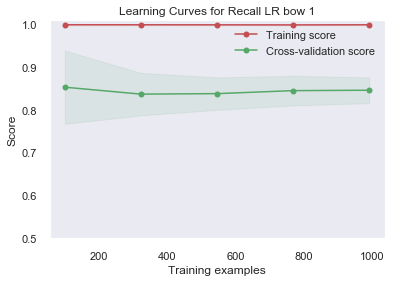

In [210]:
title = "Learning Curves for Recall LR bow 1"
test_error =[]
train_error = []
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
estimator = LogisticRegression(solver = 'lbfgs',penalty='l2',class_weight ='balanced')
plt, train_error, test_error = plot_learning_curve(estimator, title, Xtrain_bow2_ste, ytrain_bow2_ste, ylim=(0.5, 1.01), cv=cv, n_jobs=5)
plt.show()

In [211]:
train_error, test_error

([array([0.00195867, 0.00124811, 0.00118097, 0.0010667 , 0.00086523])],
 [array([0.0858283 , 0.0498114 , 0.03811058, 0.03467819, 0.0302353 ])])

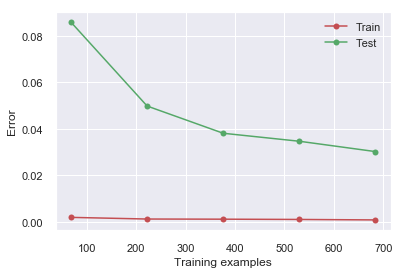

In [212]:
x = [68,222,376,530,684]
y = [0.00195867, 0.00124811, 0.00118097, 0.0010667 , 0.00086523]
z = [0.0858283 , 0.0498114 , 0.03811058, 0.03467819, 0.0302353]
plt.plot(x, y, 'o-', color="r",label='Train')
plt.plot(x, z, 'o-', color="g",label='Test')
plt.xlabel("Training examples")
plt.ylabel("Error")
plt.legend(loc="best")
plt.show()

Train score mean  [0.99257993 0.99143449 0.99281162 0.99340798 0.99289954]  +-  [0.01375056 0.00893407 0.00574558 0.00434843 0.00421809]
Test score mean   [0.77333896 0.77843926 0.77693296 0.80167646 0.80451091]  +-  [0.16755987 0.08533881 0.06364148 0.05239324 0.04678781]
cv:  ShuffleSplit(n_splits=100, random_state=42, test_size=0.2, train_size=None)
train size: [ 99 322 546 769 993]


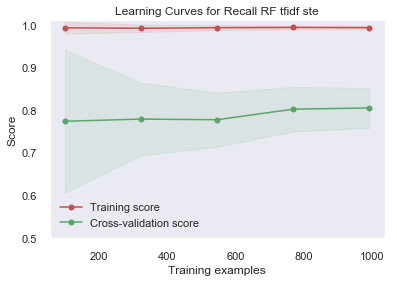

In [195]:
title = "Learning Curves for Recall RF tfidf ste"
test_error =[]
train_error = []
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42,class_weight='balanced')
plt, train_error, test_error = plot_learning_curve(estimator, title, Xtrain_tfidf_ste, ytrain_tfidf_ste, ylim=(0.5, 1.01), cv=cv, n_jobs=5)
plt.show()

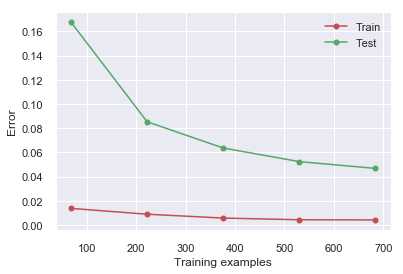

In [197]:
x = [68,222,376,530,684]
y = [0.01375056, 0.00893407, 0.00574558, 0.00434843, 0.00421809]
z = [0.16755987, 0.08533881, 0.06364148, 0.05239324, 0.04678781]
plt.plot(x, y, 'o-', color="r",label='Train')
plt.plot(x, z, 'o-', color="g",label='Test')
plt.xlabel("Training examples")
plt.ylabel("Error")
plt.legend(loc="best")
plt.show()

# Optimize parameter for best model
Logistic Regression with BoW n = 2

In [216]:
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
param_grid = dict(max_iter=max_iter,C=C)
random = RandomizedSearchCV(estimator=E, scoring='recall',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow2_ste, ytrain_bow2_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.852595 using {'max_iter': 110, 'C': 1.0}


In [219]:
best = LogisticRegression(solver = 'lbfgs',penalty='l2',class_weight ='balanced', max_iter=110,C=1.0)

# ROC

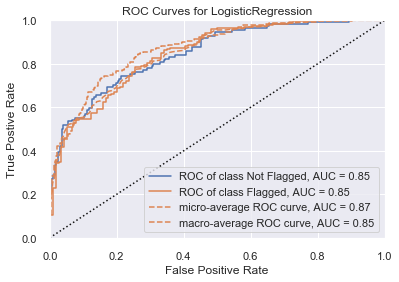

In [220]:
ROC_AUC(best, Xtrain_bow2_ste, ytrain_bow2_ste, Xtest_bow2_ste, ytest_bow2_ste)

# Precision - Recall

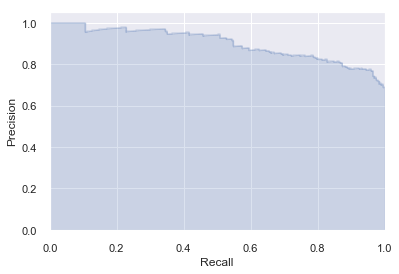

In [221]:
prec_recall(best, Xtest_bow2_ste, ytest_bow2_ste)

# K fold

In [222]:
k_fold(10, best, Xtrain_bow2_ste, ytrain_bow2_ste, 'recall')

Average scoring =  0.8507587425873512  +/-  0.01867349712300522


In [226]:
k_fold(10, best, Xtrain_bow2_ste, ytrain_bow2_ste, 'accuracy')

Average scoring =  0.7536322580645162  +/-  0.022750861666224212


In [227]:
k_fold(10, best, Xtrain_bow2_ste, ytrain_bow2_ste, 'precision')

Average scoring =  0.780359676691807  +/-  0.0365798284636118


# Most important feature

In [224]:
show_most_informative_features(feature_names_n2, best, 20)

	-3.2827	real           		2.1182	body           
	-1.1716	cal            		0.9006	hour           
	-0.8686	messag         		0.8807	woman          
	-0.7370	men            		0.7959	yes            
	-0.7052	å½ë            		0.7346	exotic         
	-0.7043	adult          		0.7296	fantasies      
	-0.6725	numb           		0.7274	ready          
	-0.6498	look           		0.7222	interestedtext 
	-0.6237	romant         		0.7039	interestedjust 
	-0.6237	sweet romant   		0.6752	honest         
	-0.6235	horny new      		0.6660	car            
	-0.5902	charge         		0.6408	safe           
	-0.5615	bad            		0.5968	miss           
	-0.5448	money          		0.5951	black          
	-0.5434	mind           		0.5636	make fast      
	-0.5395	guysnthis      		0.5539	town           
	-0.5395	guysnthis early		0.5506	discreet       
	-0.5357	interested pleas		0.5496	bony           
	-0.5147	bored          		0.5353	sexxpleas      
	-0.5001	totally        		0.5353	happy sexxpleas


# With feature reduction

Reduce Feature for reduce high variance:
Chi squared for feauture reduction
A chi-squared test finds the words that discriminate the most
One downside of this is that we are using knowledge from the dataset to select features, and thus introducing some overfitting. We could get around the overfitting in the "real world" by using a subset of the data for feature selection, and using a different subset for training the algorithm. We'll make things a bit simpler for now and skip that step.

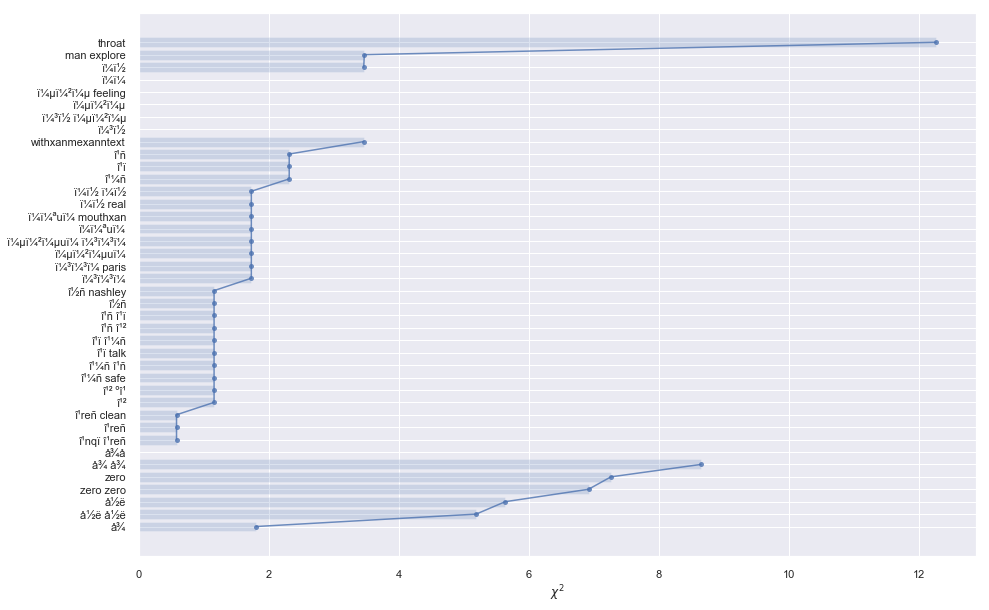

In [262]:
# feature reduction for the best feature 
Xtrain_red,  Xtest_red, feature_names_best = chi2_kbest(Xtrain_bow2_ste, ytrain_bow2_ste, Xtest_bow2_ste, feature_names_n2, 1000)

Train score mean  [0.97489554 0.97136886 0.97374086 0.97292733 0.97176419]  +-  [0.02759795 0.02261913 0.0164936  0.01374281 0.01294193]
Test score mean   [0.77494562 0.82664028 0.84713469 0.85380322 0.8616329 ]  +-  [0.12933802 0.05968419 0.04827395 0.03764433 0.0374715 ]
cv:  ShuffleSplit(n_splits=100, random_state=42, test_size=0.2, train_size=None)
train size: [ 99 322 546 769 993]


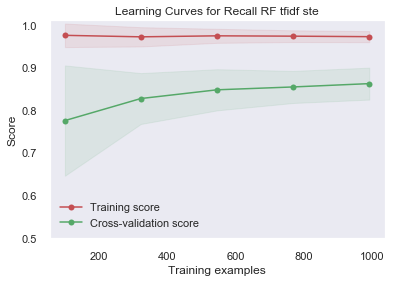

In [266]:
title = "Learning Curves for Recall RF tfidf ste"
test_error =[]
train_error = []
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42,class_weight='balanced')
plt, train_error, test_error = plot_learning_curve(estimator, title, Xtrain_red, ytrain_tfidf_ste, ylim=(0.5, 1.01), cv=cv, n_jobs=5)
plt.show()

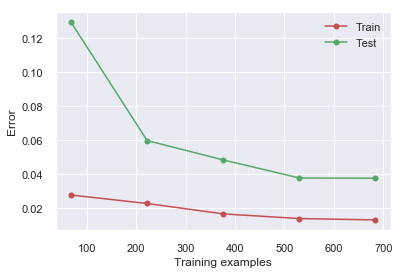

In [268]:
x = [68,222,376,530,684]
y = [0.02759795, 0.02261913, 0.0164936 , 0.01374281, 0.01294193]
z = [0.12933802, 0.05968419, 0.04827395, 0.03764433, 0.0374715]
plt.plot(x, y, 'o-', color="r",label='Train')
plt.plot(x, z, 'o-', color="g",label='Test')
plt.xlabel("Training examples")
plt.ylabel("Error")
plt.legend(loc="best")
plt.show()

In [269]:
k_fold(10, best, Xtrain_red, ytrain_bow2_ste, 'recall')
k_fold(10, best, Xtrain_red, ytrain_bow2_ste, 'accuracy')
k_fold(10, best, Xtrain_red, ytrain_bow2_ste, 'precision')

Average scoring =  0.8577541146501695  +/-  0.0494823146780954
Average scoring =  0.7962516129032259  +/-  0.042381768703279886
Average scoring =  0.8265074102926914  +/-  0.03889348773286395
